# Figure 2

In [1]:
# Load in packages
library(tidyverse)
library(data.table)
library(readxl)
library(dplyr)
library(stringr)
library(ggplot2)
install.packages("ggbreak")
library(ggbreak)
library(tidyr)
install.packages("ggpubr")
library(ggpubr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose





The downloaded binary packages are in
	/var/folders/d3/vjc_50q165z6232gypbw3sq40000gp/T//RtmpwxlY00/downloaded_packages


ggbreak v0.1.2

If you use ggbreak in published research, please cite the following
paper:

S Xu, M Chen, T Feng, L Zhan, L Zhou, G Yu. Use ggbreak to effectively
utilize plotting space to deal with large datasets and outliers.
Frontiers in Genetics. 2021, 12:774846. doi: 10.3389/fgene.2021.774846





The downloaded binary packages are in
	/var/folders/d3/vjc_50q165z6232gypbw3sq40000gp/T//RtmpwxlY00/downloaded_packages


Clear environment: 

In [2]:
rm(list=ls())

In [3]:
setwd("")

Set your datasets below and read in the files containing all indels ≤ 50bp for each dataset:

In [4]:
db_name_1 = "gnomAD"
db_name_2 = "IGM"

df_1 = fread("gnomad.exomes.r2.1.1.sites_indelsonly_rAF_lt50bp.csv")
df_2 = fread("2023-03-23_IGM_n39367_indelsonly_rAF_lt50bp.csv")

Read in suspicious indels file for each dataset: 

In [5]:
suspicious_indels_10bp_df_1 = fread("gnomad.exomes.r2.1.1.sites_indelsonly_rAF_bp10_SuspiciousIndels.lt50bp.csv")
suspicious_indels_20bp_df_1 = fread("gnomad.exomes.r2.1.1.sites_indelsonly_rAF_bp20_SuspiciousIndels.lt50bp.csv")
suspicious_indels_30bp_df_1 = fread("gnomad.exomes.r2.1.1.sites_indelsonly_rAF_bp30_SuspiciousIndels.lt50bp.csv")
suspicious_indels_40bp_df_1 = fread("gnomad.exomes.r2.1.1.sites_indelsonly_rAF_bp40_SuspiciousIndels.lt50bp.csv")

In [6]:
suspicious_indels_10bp_df_2 = fread("2023-03-23_IGM_n39367_indelsonly_rAF_bp10_SuspiciousIndels.lt50bp.csv")
suspicious_indels_20bp_df_2 = fread("2023-03-23_IGM_n39367_indelsonly_rAF_bp20_SuspiciousIndels.lt50bp.csv")
suspicious_indels_30bp_df_2 = fread("2023-03-23_IGM_n39367_indelsonly_rAF_bp30_SuspiciousIndels.lt50bp.csv")
suspicious_indels_40bp_df_2 = fread("2023-03-23_IGM_n39367_indelsonly_rAF_bp40_SuspiciousIndels.lt50bp.csv")

Declare your bp range:

In [7]:
bp_range = c("10", "20", "30", "40")

Separate your VarID into CHR, POS, REF, ALT

In [8]:
df_1 = separate(df_1, col = VarID, into = c("CHR", "POS", "REF", "ALT"), sep = "-")
df_2 = separate(df_2, col = VarID, into = c("CHR", "POS", "REF", "ALT"), sep = "-")

Calculate bin length and create individual graphs: 

In [9]:
for (i in bp_range) {
  print(i)
  
  ## Find the bins that the suspicious indels are in
  temp_bins_1 = distinct(get(paste0("suspicious_indels_", i, "bp_df_1")) %>% select(paste0("GID_bp", i)))
  temp_bins_2 = distinct(get(paste0("suspicious_indels_", i, "bp_df_2")) %>% select(paste0("GID_bp", i)))
  
  temp_var = paste0("GID_bp", i)
  
  temp_df_1 = paste0("filtered_df_1_", i)
  temp_df_2 = paste0("filtered_df_2_", i)
  
  ## Keep the bins that have at least one suspicious indel and have to have at least 2 indels (the second indel doesn't have to be suspicious)
  assign(temp_df_1,  df_1 %>% filter(df_1[[temp_var]] %in% temp_bins_1[[temp_var]]) %>% group_by(get(temp_var)) %>% filter(n()>1))
  assign(temp_df_2,  df_2 %>% filter(df_2[[temp_var]] %in% temp_bins_2[[temp_var]]) %>% group_by(get(temp_var)) %>% filter(n()>1))
  
  #find start and end indels 
  assign(temp_df_1, get(temp_df_1) %>% group_by(get(temp_var)) %>% mutate(start_indel = as.numeric(min(POS)), end_indel = as.numeric(max(POS))) %>% ungroup())
  assign(temp_df_2, get(temp_df_2) %>% group_by(get(temp_var)) %>% mutate(start_indel = as.numeric(min(POS)), end_indel = as.numeric(max(POS))) %>% ungroup())
  
  ## calculate the length of bin 
  assign(temp_df_1, get(temp_df_1) %>% mutate (bin_length = get(temp_df_1)$end_indel - get(temp_df_1)$start_indel))
  assign(temp_df_2, get(temp_df_2) %>% mutate (bin_length = get(temp_df_2)$end_indel - get(temp_df_2)$start_indel))
  
  ## Get a chart with the number of bins with that bin length
  temp_chart_1 = paste0("bin_len_1_", i)
  temp_chart_2 = paste0("bin_len_2_", i)
  
  assign(temp_chart_1, distinct(get(temp_df_1) %>% select (paste0("GID_bp", i), "bin_length")))
  assign(temp_chart_2, distinct(get(temp_df_2) %>% select (paste0("GID_bp", i), "bin_length")))
  
  ## Get a graph 
  graph_df1 = paste0("graph_df1_bp", i)
  graph_df2 = paste0("graph_df2_bp", i)
  
  
  ## Make graphs 
  assign(graph_df1, ggplot(get(temp_chart_1), aes(x = bin_length)) +
    geom_histogram(aes(y = ..density..), colour= "black", fill = "white", binwidth = 1) +
    geom_density(fill="grey", alpha = .5) + 
    scale_x_continuous(breaks =seq(from = 0, to = 1000, by = 20), limits = c(0, 1000)) + 
    scale_x_break(breaks = c(80, 800), scales = 0.25, ticklabels = c(800, 900, 1000)) +
    ylim(0, 0.3) + 
    labs(title = paste0(db_name_1, ": ", i, "bp window"), x = "Bin Lengths (bps)") + 
    theme(axis.text=element_text(size=20), axis.text.x = element_text(angle = 90), axis.title=element_text(size=20), plot.title=element_text(size=32, hjust = 0.5, margin = margin( 1, 1, 1, 1, "cm")), plot.margin = margin( 2, 2, 2, 2, "cm"), axis.title.y = element_text(margin = margin( 1, 1, 1, 1, "cm"), angle = 90)))
  
  assign(graph_df2, ggplot(get(temp_chart_2), aes(x = bin_length)) +
    geom_histogram(aes(y = ..density..), colour= "black", fill = "white", binwidth = 1) +
    geom_density(fill="grey", alpha = .5) + 
    scale_x_continuous(breaks =seq(from = 0, to = 1000, by = 20), limits = c(0, 1000)) + 
    scale_x_break(breaks = c(80, 800), scales = 0.25, ticklabels = c(800, 900, 1000)) +
    ylim(0, 0.3) + 
    labs(title = paste0(db_name_2, ": ", i, "bp window"), x = "Bin Lengths (bps)") + 
    theme(axis.text=element_text(size=20),  axis.text.x = element_text(angle = 90), axis.title=element_text(size=20), plot.title=element_text(size=32, hjust = 0.5, margin = margin( 1, 1, 1, 1, "cm")), plot.margin = margin( 2, 2, 2, 2, "cm"), axis.title.y = element_text(margin = margin( 1, 1, 1, 1, "cm"), angle = 90)))
}

[1] "10"
[1] "20"
[1] "30"
[1] "40"


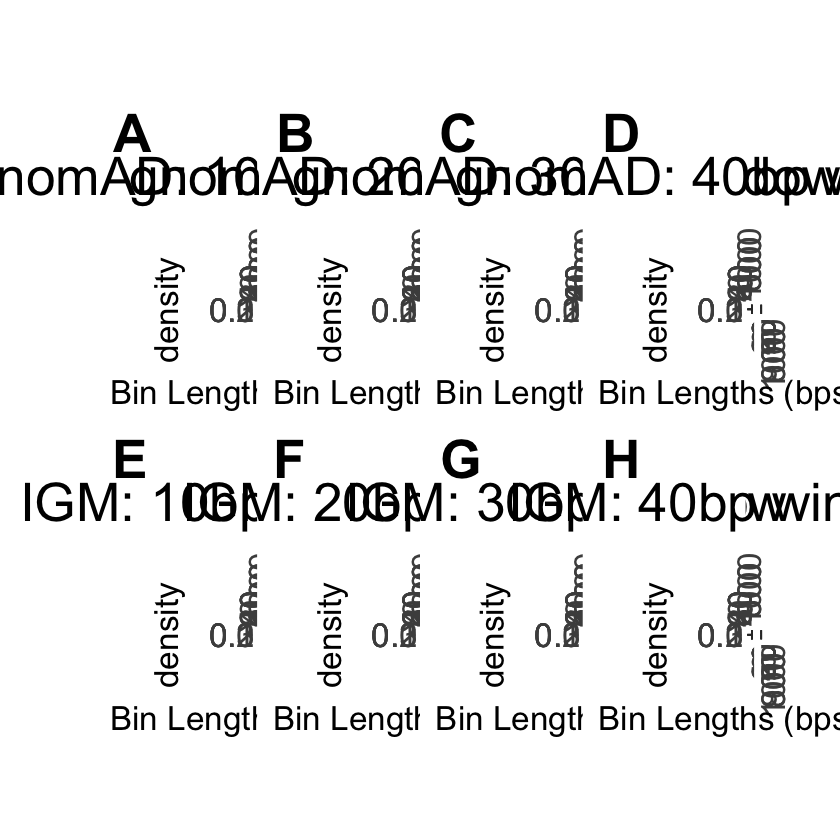

In [10]:
ggarrange(print(graph_df1_bp10),
          print(graph_df1_bp20),
          print(graph_df1_bp30),
          print(graph_df1_bp40),
          print(graph_df2_bp10),
          print(graph_df2_bp20),
          print(graph_df2_bp30),
          print(graph_df2_bp40),
          labels = c("A", "B", "C", "D", "E", "F", "G", "H"),
          ncol = 4, nrow = 2, font.label = list(size = 32, color = "black")) + theme(plot.margin = unit(c(2,2,2,2), "cm"))
ggsave("Fig2.jpg", width = 80, height = 40, units = c("cm"), dpi = 300)

# Written Results Section

## To find the mean and median bin lengths. 

In [11]:
for (i in bp_range) {
  # get the dataframe with all the indels in a bin with a suspicious indel 
  temp_var1 = paste0("filtered_df_1_", i)
  temp_var2 = paste0("filtered_df_2_", i)
  
  # find mean and median 
  mean_df1 = paste0("mean_bin_len_df1_bp", i)
  mean_df2 = paste0("mean_bin_len_df2_bp", i)
  
  gID = paste0("GID_bp", i)

  
  ## remember: got to collapse by gID 
  assign(mean_df1, mean(unique(get(temp_var1) %>% select(gID, bin_length))$bin_length))
  assign(mean_df2, mean(unique(get(temp_var2) %>% select(gID, bin_length))$bin_length))
  
  median_df1 = paste0("median_bin_len_df1_bp", i)
  median_df2 = paste0("median_bin_len_df2_bp", i)
  
  assign(median_df1, median(unique(get(temp_var1) %>% select(gID, bin_length))$bin_length))
  assign(median_df2, median(unique(get(temp_var2) %>% select(gID, bin_length))$bin_length))
  
  print(paste0("Mean bin length for ", db_name_1, " and bp window ", i, ": ", get(mean_df1)))
  print(paste0("Mean bin length for ", db_name_2, " and bp window ", i, ": ", get(mean_df2)))
  
  print(paste0("Median bin length for ", db_name_1, " and bp window ", i, ": ", get(median_df1)))
  print(paste0("Median bin length for ", db_name_2, " and bp window ", i, ": ", get(median_df2)))
}


Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(gID)

  # Now:
  data %>% select(all_of(gID))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


[1] "Mean bin length for gnomAD and bp window 10: 3.86685651004588"
[1] "Mean bin length for IGM and bp window 10: 4.223479652492"
[1] "Median bin length for gnomAD and bp window 10: 2"
[1] "Median bin length for IGM and bp window 10: 3"
[1] "Mean bin length for gnomAD and bp window 20: 8.81729121444076"
[1] "Mean bin length for IGM and bp window 20: 10.0574041642343"
[1] "Median bin length for gnomAD and bp window 20: 6"
[1] "Median bin length for IGM and bp window 20: 7"
[1] "Mean bin length for gnomAD and bp window 30: 13.6617282620407"
[1] "Mean bin length for IGM and bp window 30: 16.2973681909592"
[1] "Median bin length for gnomAD and bp window 30: 11"
[1] "Median bin length for IGM and bp window 30: 12"
[1] "Mean bin length for gnomAD and bp window 40: 18.0122436407505"
[1] "Mean bin length for IGM and bp window 40: 22.6996283729197"
[1] "Median bin length for gnomAD and bp window 40: 14"
[1] "Median bin length for IGM and bp window 40: 16"


## To find the percentage of bins with suspicious indels with bins < X bp for each bp window

In [12]:
for (i in bp_range) {
  
  ## get the bin_len dataframe 
  ben_len_1 = paste0("bin_len_1_", i)
  ben_len_2 = paste0("bin_len_2_", i)
  
  ## assign the count window variable 
  count_window_1 = paste0("count_window", i, "_df1")
  count_window_2 = paste0("count_window", i, "_df2")
  
  assign(count_window_1, get(ben_len_1) %>% group_by(bin_length) %>% count(bin_length))
  assign(count_window_2, get(ben_len_2) %>% group_by(bin_length) %>% count(bin_length))
  
  ## find the percentage 
  percent_df1 = paste0("percent_lt_", i, "bp_window_", i, "df1")
  percent_df2 = paste0("percent_lt_", i, "bp_window_", i, "df2")
  
  assign(percent_df1, sum((get(count_window_1) %>% filter(bin_length < as.numeric(i)))$n) / sum(get(count_window_1)$n) * 100 )
  assign(percent_df2, sum((get(count_window_2) %>% filter(bin_length < as.numeric(i)))$n) / sum(get(count_window_2)$n) * 100 )
  
  print(paste0("Percent less than ", i, " bps, window ", i, " is ", get(percent_df1), "% for dataset ", db_name_1))
  print(paste0("Percent less than ", i, " bps, window ", i, " is ", get(percent_df2), "% for dataset ", db_name_2))

}

[1] "Percent less than 10 bps, window 10 is 89.7547856351843% for dataset gnomAD"
[1] "Percent less than 10 bps, window 10 is 88.5230909922268% for dataset IGM"
[1] "Percent less than 20 bps, window 20 is 88.8609619559008% for dataset gnomAD"
[1] "Percent less than 20 bps, window 20 is 85.4835571122786% for dataset IGM"
[1] "Percent less than 30 bps, window 30 is 89.5997198577739% for dataset gnomAD"
[1] "Percent less than 30 bps, window 30 is 83.6233277957506% for dataset IGM"
[1] "Percent less than 40 bps, window 40 is 91.0341641212557% for dataset gnomAD"
[1] "Percent less than 40 bps, window 40 is 82.582000323154% for dataset IGM"


## We observed XX bins with suspicious indels using the 10bp sliding window, and XX, XX, XX for the 20bp, 30bp and 40bp sliding windows respectively.

In [13]:
for (i in bp_range) {
  # get the dataframe with all the indels in a bin with a suspicious indel 
  temp_var1 = paste0("filtered_df_1_", i)
  temp_var2 = paste0("filtered_df_2_", i)
  
  # assign a variable for the bins 
  bins_df1 = paste0 ("bins_", i, "df1")
  bins_df2 = paste0 ("bins_", i, "df2")
  
  assign (bins_df1, nrow(unique(get(temp_var1)[paste0("GID_bp", i)])))
  assign (bins_df2, nrow(unique(get(temp_var2)[paste0("GID_bp", i)])))
  
  print(paste0("Number of bins with suspicious indels in ", db_name_1, " is: ", get(bins_df1)))
  print(paste0("Number of bins with suspicious indels in ", db_name_2, " is: ", get(bins_df2)))
}

[1] "Number of bins with suspicious indels in gnomAD is: 31605"
[1] "Number of bins with suspicious indels in IGM is: 8748"
[1] "Number of bins with suspicious indels in gnomAD is: 35012"
[1] "Number of bins with suspicious indels in IGM is: 10278"
[1] "Number of bins with suspicious indels in gnomAD is: 37124"
[1] "Number of bins with suspicious indels in IGM is: 11437"
[1] "Number of bins with suspicious indels in gnomAD is: 38959"
[1] "Number of bins with suspicious indels in IGM is: 12378"


## Make table for above data (Supplementary Tables S3 and S4). 

In [14]:
df_1_bins_sus_indels = c(bins_10df1, bins_20df1, bins_30df1, bins_40df1)
df_1_mean_bin_len = c(mean_bin_len_df1_bp10, mean_bin_len_df1_bp20, mean_bin_len_df1_bp30, mean_bin_len_df1_bp40)
df_1_median_bin_len = c(median_bin_len_df1_bp10, median_bin_len_df1_bp20, median_bin_len_df1_bp30, median_bin_len_df1_bp40)
df_1_bins_prct_under_window_size = c(percent_lt_10bp_window_10df1, percent_lt_20bp_window_20df1, percent_lt_30bp_window_30df1, percent_lt_40bp_window_40df1)

df_1_summary = data.frame(bp_range, df_1_bins_sus_indels, df_1_mean_bin_len, df_1_median_bin_len, df_1_bins_prct_under_window_size)
df_1_summary 

df_2_bins_sus_indels = c(bins_10df2, bins_20df2, bins_30df2, bins_40df2)
df_2_mean_bin_len = c(mean_bin_len_df2_bp10, mean_bin_len_df2_bp20, mean_bin_len_df2_bp30, mean_bin_len_df2_bp40)
df_2_median_bin_len = c(median_bin_len_df2_bp10, median_bin_len_df2_bp20, median_bin_len_df2_bp30, median_bin_len_df2_bp40)
df_2_bins_prct_under_window_size = c(percent_lt_10bp_window_10df2, percent_lt_20bp_window_20df2, percent_lt_30bp_window_30df2, percent_lt_40bp_window_40df2)

df_2_summary = data.frame(bp_range, df_2_bins_sus_indels, df_2_mean_bin_len, df_2_median_bin_len, df_2_bins_prct_under_window_size)
df_2_summary 


bp_range,df_1_bins_sus_indels,df_1_mean_bin_len,df_1_median_bin_len,df_1_bins_prct_under_window_size
<chr>,<int>,<dbl>,<dbl>,<dbl>
10,31605,3.866857,2,89.75479
20,35012,8.817291,6,88.86096
30,37124,13.661728,11,89.59972
40,38959,18.012244,14,91.03416


bp_range,df_2_bins_sus_indels,df_2_mean_bin_len,df_2_median_bin_len,df_2_bins_prct_under_window_size
<chr>,<int>,<dbl>,<dbl>,<dbl>
10,8748,4.22348,3,88.52309
20,10278,10.05740,7,85.48356
30,11437,16.29737,12,83.62333
40,12378,22.69963,16,82.58200


In [15]:
fwrite(df_1_summary, "supplementary_table_S3.csv")
fwrite(df_2_summary, "supplementary_table_S4.csv")